# MLB - Can you predict pitcher's ERA?

# Introduction

In this tutorial I will take you through some basic steps to process baseball statistics.  
Which includes tasks like importing libraries, collecting data, cleaning up the data and drawing graphs.  
Statistics is very important in the world of baseball, for example "Moneyball" the book and film which were made based off of how well the Oakland A's did with an extremely low budget because the manager assembled a team based on statistical values of the players.  
  
This is also very true for Fanyasy Baseball players such as myself. It's important to study players' past perfomences and predict who will continue to perform well and who to avoid when you are drafting.  
  
Major Leauge Baseball is constantly looking for new technologies to track different types of statistical values.  
In the year 2008, MLB started to implimented a tool called "Statcast", Statcast is a high-speed, high-accuracy, automated tool developed to analyze player movements and athletic abilities.  
This tracks information like, pitch speed, types of pitch, rotation speed, hitting average against individual pitchers, catch probablility and hundres more.  
  
The goal for this tutorial is to look at top 10 pitchers with the lowrst ERA from year 2010 to 2015 and study the following stats:  
* Pitch Velocity
* Pitch percentage inside the zone
* Pitches percentage outside the zone
* Fastball thrown percentage
* Offspeed thrown percentage
* Strikeouts per 9 innings (K/9) 

and see if we can use these values to predict pitcher ERA in 2016.

# Tutorial content

In this tutorial, we will use dataset provided by <a href='http://www.seanlahman.com/baseball-archive/statistics/'>Sean Lahman</a>. Sean's dataset provides detailed information from team franchises to individual player performences. Today we will be using ERA, Strikeouts and Innings pitched from his dataset.  
  
We will also use another dataset from <a = href="https://baseballsavant.mlb.com/statcast_search">Baseball Savant</a>. This website allows you to look up statistics collected by MLB's statcast tool. We will collect the stats mentioned in the introduction form this website.  

# Imports

For this tutorial we will use the following libraries to help us with our prediction.  

In [39]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import sklearn

# Loading Data

Now that we have imported all the necessary libraries for the task, we will need to load data sets to process.  
As mentioned before, we will be using datas provided by Sean Lahman and Bseball Savant.  
Below I provided links for all the data sets that we will need for this tutorial.  
* <a herf="lahman2016.sqlite">lahman2016.sqlite</a>  
* <a herf="statcast_velocity.csv">statcast_velocity.csv</a>  
* <a herf="statcast_inzone.csv">statcast_inzone.csv</a>  
* <a herf="statcast_outzone.csv">statcast_outzone.csv</a>  
* <a herf="statcast_offspeed.csv">statcast_offspeed.csv</a>  
* <a herf="statcast_fastball.csv">statcast_fastball.csv</a>  
These files should be put in the same folder as the Jupyter Notebook.  
  
For the first part we will use lahman2016.sqlite.  
The following command shows you how to load a sqlite into your notebook.  

In [40]:
lahman_2016 = 'lahman2016.sqlite'
conn = sqlite3.connect(lahman_2016)

Now that we have the sql filed loaded in, we will need to write a SQL query to get the infomation we want from it.  
Below is the command to get a player's name and their ERA + K/9 for years from 2010 and onward and pitched atleast 20 games.    
Noticed that the data set doesnt not provide a column with First Name + Last Name so we have to combine them manually.  
Also we had to calcualte the K/9 by ourselves which is simply just 9*(Strikeouts/Innings pitched).  
  
**R.A. Dickey's name format is differnt than the second data set we will use later, so I made a change here**

In [41]:
pitcher_query = """SELECT (MASTER.nameFirst||\" \"||MASTER.nameLast) AS player_name,ERA, yearID AS year,
                (9*(SO/(IPOuts/3.0))) AS K9
                   FROM Pitching, MASTER
                   WHERE Pitching.playerID == MASTER.playerID AND Pitching.GS >= 20 AND
                         Pitching.yearID >=2010
                   ORDER BY yearID, ERA"""
pitcher_stats = pd.read_sql(pitcher_query, conn)
pitcher_stats.head()

,player_name,ERA,year,K9
0,Felix Hernandez,2.27,2010,8.363151
1,Josh Johnson,2.30,2010,9.114338
2,Clay Buchholz,2.33,2010,6.218810
3,Adam Wainwright,2.42,2010,8.322721
4,Roy Halladay,2.44,2010,7.863032


As you can see form the comman below, each yaer contains more than 100 pitchers, but we only want the top10.  
I wrote a the function "top10" to help us out here.  
Since the dataframe was ordered by ERA in ascending order, we can just filter by the year and use head to get the first 10.  

In [42]:
pitcher_stats['year'].value_counts()

2011    130
2013    124
2010    124
2014    123
2015    121
2016    120
2012    118
Name: year, dtype: int64

In [43]:
def top10(year):
    sub_df = pitcher_stats.loc[pitcher_stats['year'] == year].head(10)
    return sub_df

top10_2010 = top10(2010)
top10_2011 = top10(2011)
top10_2012 = top10(2012)
top10_2013 = top10(2013)
top10_2014 = top10(2014)
top10_2015 = top10(2015)

top10_2010

,player_name,ERA,year,K9
0,Felix Hernandez,2.27,2010,8.363151
1,Josh Johnson,2.30,2010,9.114338
2,Clay Buchholz,2.33,2010,6.218810
3,Adam Wainwright,2.42,2010,8.322721
4,Roy Halladay,2.44,2010,7.863032
5,Jaime Garcia,2.70,2010,7.273469
6,David Price,2.72,2010,8.108626
7,Tim Hudson,2.83,2010,5.470845
8,R. A. Dickey,2.84,2010,5.369025
9,Ubaldo Jimenez,2.88,2010,8.688722


Now that we have cleaned up the first dataset, lets dive into the 5 other data sets.  
I also wrote a function for this, since I will pretty much do the same commands for the files, its simplier this way.  
the function takes in the csv file names, and the columns that we want, and column name you want to change.  
**I needed to change the column names because they all have the same name, which would cause confusion when I merge them**

In [44]:
def clean_df(filename, columns, rename_target, rename_value):
    read = pd.read_csv(filename+".csv")
    temp = read[columns].rename(columns={rename_target : rename_value})
    return temp

So you are probably wonderign why I'm cleaning up these data sets.  
**Because its a mess and contains too much extra informations that we dont need**  
Let me show you what it looks like before cleaning it up.  

In [45]:
example = pd.read_csv("statcast_velocity.csv")
example.head()

,pitches,player_id,player_name,year,total_pitches,pitch_percent,ba,iso,babip,slg,...,takes,eff_min_vel,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance
0,2935,592789,Noah Syndergaard,2016,2935,100.0,0.243,0.108,0.336,0.351,...,1442,0.6,6.77,109,152,111,146,290,311,293
1,1727,543037,Gerrit Cole,2013,1727,100.0,0.253,0.084,0.313,0.336,...,895,null,null,null,null,null,null,null,null,null
2,2798,518774,Matt Harvey,2015,2798,100.0,0.222,0.122,0.277,0.344,...,1430,-1.1,6.02,113,149,111,146,292,307,291
3,3239,543037,Gerrit Cole,2015,3239,100.0,0.239,0.097,0.308,0.336,...,1659,-0.3,6.20,108,151,110,148,297,318,292
4,2697,518774,Matt Harvey,2013,2697,100.0,0.209,0.073,0.283,0.282,...,1326,null,null,null,null,null,null,null,null,null


Now lets runs some commands using the function above to clean them up.  

In [46]:
statcast_velocity = clean_df('statcast_velocity',['player_name','year','velocity'],'','')
statcast_inzone = clean_df('statcast_inzone',['player_name','year','pitch_percent'],'pitch_percent', 'inzone')
statcast_outzone = clean_df('statcast_outzone',['player_name','year','pitch_percent'],'pitch_percent', 'outzone')
statcast_fastball = clean_df('statcast_fastball',['player_name','year','pitch_percent'],'pitch_percent', 'fastball')
statcast_offspeed = clean_df('statcast_offspeed',['player_name','year','pitch_percent'],'pitch_percent', 'offspeed')

statcast_velocity.head()

,player_name,year,velocity
0,Noah Syndergaard,2016,94.8
1,Gerrit Cole,2013,93.4
2,Matt Harvey,2015,93.2
3,Gerrit Cole,2015,93.0
4,Matt Harvey,2013,92.7


Much easier to read right?  
Now thats combine all the different stats into one beautiful dataframe.  
  
**remember the top10 function we used before to create the list of top 10 pitchers from before?  
now we combine the lists and merge them with the rest of the stats**

In [47]:
top10s = top10_2010.append([top10_2011,top10_2012,top10_2013,top10_2014,top10_2015])

statcast = (statcast_velocity.merge(statcast_inzone,on=['player_name','year'])
                             .merge(statcast_outzone,on=['player_name','year'])
                             .merge(statcast_fastball,on=['player_name','year'])
                             .merge(statcast_offspeed,on=['player_name','year'])
                             .merge(top10s,on=['player_name','year']))
statcast.head()

,player_name,year,velocity,inzone,outzone,fastball,offspeed,ERA,K9
0,Matt Harvey,2015,93.2,51.82,48.18,60.76,38.88,2.71,8.936620
1,Gerrit Cole,2015,93.0,50.32,49.68,66.90,32.91,2.60,8.740385
2,Matt Harvey,2013,92.7,52.65,47.31,56.77,43.05,2.27,9.639252
3,Josh Johnson,2010,92.7,48.69,51.14,61.78,37.68,2.30,9.114338
4,Ubaldo Jimenez,2010,92.3,47.89,50.86,76.33,21.78,2.88,8.688722


Would you look at that. Its simple and easy to read.  
Now we are officially done with collecting and cleaning the data.  
lets move on to visualizing it.

# Visualization - Graphs

Now that we have all the information in on dataframe, this is where the fun begins.  
We will make 6 different of the different stats in relation to ERA.  
This part can get a little tricky since we are using a loop to create these graphs and drawing a regression line through them.

Before we start plotting the data, lets write a linear regression function to help us get the m and b value for drawing a line.  

In [48]:
def reg_line(df, x, y):
    columns = {'velocity':2, 'inzone':3, 'outzone':4, 'fastball':5, 'offspeed':6, 'ERA':7, 'K9':8}
    npMatrix = np.matrix(df)
    X, Y = npMatrix[:,columns[x]], npMatrix[:,columns[y]]
    model = sklearn.linear_model.LinearRegression().fit(X,Y)
    m = model.coef_[0]
    b = model.intercept_
    return m,b

Then we can generate the needed m and b value for each of the statistical value vs ERA and putting them in array which will be useful when we draw the graphs inside a loop.

In [49]:
v_m, v_b =  reg_line(statcast, 'velocity', 'ERA')
in_m, in_b =  reg_line(statcast, 'inzone', 'ERA')
out_m, out_b =  reg_line(statcast, 'outzone', 'ERA')
fast_m, fast_b =  reg_line(statcast, 'fastball', 'ERA')
off_m, off_b =  reg_line(statcast, 'offspeed', 'ERA')
k9_m, k9_b =  reg_line(statcast, 'K9', 'ERA')

X = [statcast['velocity'],statcast['inzone'],statcast['outzone'],
     statcast['fastball'],statcast['offspeed'],statcast['K9']]
Y = [statcast['ERA'],statcast['ERA'],statcast['ERA'],statcast['ERA'],statcast['ERA'],statcast['ERA']]
reg = [[v_m,v_b],[in_m,in_b],[out_m,out_b],[fast_m,fast_b],[off_m,off_b],[k9_m,k9_b]]
titles = ['Velocity','Pitch inside the zone','Pitch outside the zone','Fastball','Offspeed','Strikeouts per 9innings']

Here coems the actual drawing part.  
we use the creasing value of idx to make sure the values are drawn seperately.  
Using title,xlabel and ylabel to set the corresponding titles for the graphs.

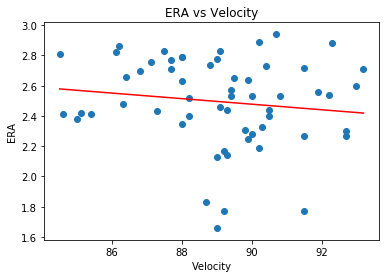

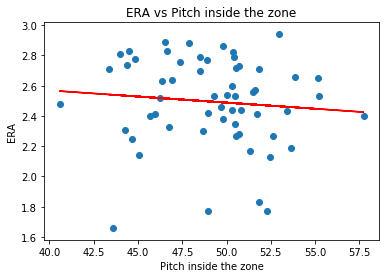

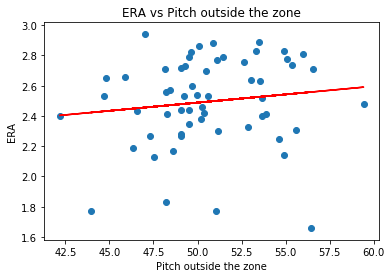

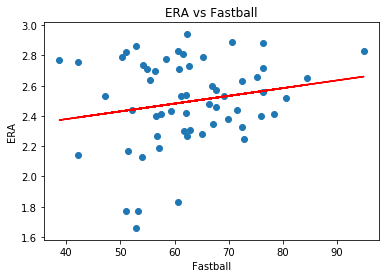

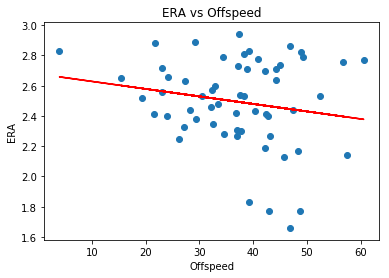

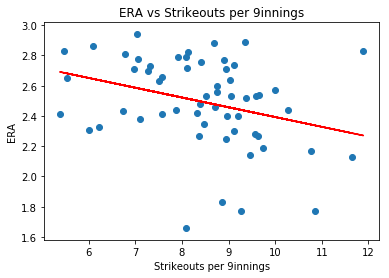

In [50]:
plots = zip(X,Y)
def loop_plot(plots):
    figs={}
    axs={}
    for idx,plot in enumerate(plots):
        figs[idx]=plt.figure()
        axs[idx]=figs[idx].add_subplot(111)
        axs[idx].scatter(plot[0],plot[1])
        axs[idx].plot(plot[0], plot[0]*reg[idx][0]+reg[idx][1], color="red")
        plt.title('ERA vs ' + titles[idx])
        plt.xlabel(titles[idx])
        plt.ylabel('ERA')
    plt.show()

loop_plot(plots)

Lets look at the graphs and interpert them  
  
**ERA vs Velocity:** Regression line shows that ERA lowers as Velocity goes up.  
**ERA vs Pitches inside the zone:**  Regression line shows that ERA lowers if pitches are inside the zone.  
**ERA vs Pitches outside the zone:** Regression line shows that ERA goes up if pitches are outside the zone.  
**ERA vs Fastball pitches:** Regression line shows that ERA goes up if more fastballs are used.  
**ERA vs Offspeed pitches:** Regression line shows that ERA lowers if more offspeed pitches are used.  
**ERA vs K/9:** Regression line shows that ERA lowers as K/9 goes up.  

With this imformation lets see if we can predict pitchers with era lower than or equal to 2.5 in 2016.  

In [51]:
velocity = str(round((((2.5-v_b)/(v_m))[0]),2))
inzone = str(round((((2.5-in_b)/(in_m))[0]),2))
offspeed = str(round((((2.5-off_b)/(off_m))[0]),2))
k9 = str(round((((2.5-k9_b)/(k9_m))[0]),2))

print ("Basd on the m and b values we calculated. pitchers with era lower than or equal to 2.5 should have")
print ("Pitch velocity >= " + velocity + " MPH")
print ("pitches inside the zone >= " + inzone + "%")
print ("Offspeed pitch usage >= " + offspeed + "%")
print ("Strikeouts per 9innings >= " + k9)

Basd on the m and b values we calculated. pitchers with era lower than or equal to 2.5 should have
Pitch velocity >= 88.79 MPH
pitches inside the zone >= 48.54%
Offspeed pitch usage >= 35.91%
Strikeouts per 9innings >= 8.34


Now thats filter the data frame with these requirements and see what happens.

In [52]:
temp = (statcast_velocity.merge(statcast_inzone,on=['player_name','year'])
                             .merge(statcast_outzone,on=['player_name','year'])
                             .merge(statcast_fastball,on=['player_name','year'])
                             .merge(statcast_offspeed,on=['player_name','year'])
                             .merge(pitcher_stats,on=['player_name','year']))

result = temp.loc[temp['year'] == 2016]
result = result.loc[result['velocity'] >= float(velocity)]
result = result.loc[result['K9'] >= float(k9)]
result = result.loc[result['inzone'] >= float(inzone)]
result = result.loc[result['offspeed'] >= float(offspeed)]
result

,player_name,year,velocity,inzone,outzone,fastball,offspeed,ERA,K9
0,Noah Syndergaard,2016,94.8,49.10,50.90,58.94,40.68,2.60,10.682396
20,Jacob deGrom,2016,90.9,51.15,48.81,59.90,40.06,3.04,8.695946
30,Max Scherzer,2016,90.5,51.60,48.26,56.99,42.76,2.96,11.194161
44,Corey Kluber,2016,90.1,48.54,51.46,52.78,47.01,3.14,9.502326
46,Justin Verlander,2016,90.0,49.40,50.60,56.73,43.10,3.04,10.040996


Seems like our hypothesis was wrong. Even though these players fits the requirements state above. all of their ERA's are above 2.5. 
  
There are a couple of things I learned from this result.  
1. Our sample size was too small, using just top 10 lowest ERA pitchers from 2010 to 2015 give us only 60 samples.  
2. There might be more variables to consider, such as opponents batting average. Which leads me to think that maybe the data should've been split into American League and National League, since American League has a DH position that might lead to pitchers having higher ERA.  
3. Whether the pitch was inside or outside the zome might not have that much to do with ERA, other things such as Ball Movement might have more to do with it since that could lead to striking out more batters.
  
  

# Conclusion 

There are a lot more to consider if I want to accurately predict pitcher's ERA than I initially thought.  
Fortunately for MLB's statcast tool, I will be able to try out more statistical value to hopefully come up with a better solution and equation for this task.  
  
Thank you for reading through my tutorial.  
It was a great experience for me to pratice the material that I leanred from my data science class.  
Hopefully this tutorial will help you get started on your journey as a beginner data scientist and become a better fantasy baseball player. 